In [142]:
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
from operator import add

In [167]:

class OptionType(Enum):
    CALL = 1
    PUT = 2

class OrderType(Enum):
    BUY = 1
    SELL = 2

In [174]:
class Option:
    def __init__(self, type, order, strike_price, option_price):
        self.type = type
        self.order = order
        self.strike_price = strike_price
        self.option_price = option_price

    def __str__(self) -> str:
        name  = ""
        if(self.type == OptionType.CALL):
            name += "CALL OPTION"
        elif(self.type == OptionType.PUT):
            name += "PUT OPTION"
        name += " "
        if(self.order == OrderType.BUY):
            name += "BUY"
        elif(self.order == OrderType.SELL):
            name += "SELL"
            
        return name
    

    def f(self, point): 
        if(self.type == OptionType.CALL): 
            if(self.order == OrderType.BUY):
                if(point < self.strike_price):
                    return -self.option_price
                else:
                    return point - self.option_price - self.strike_price
            elif(self.order == OrderType.SELL):
                if(point < self.strike_price):
                    return self.option_price
                else: 
                    return self.option_price - (point - self.strike_price)
        elif(self.type == OptionType.PUT):
            if(self.order == OrderType.BUY):
                if(point > self.strike_price):
                    return -self.option_price
                else:
                    return (self.strike_price - point) - self.option_price
            elif(self.order == OrderType.SELL):
                if(point > self.strike_price):
                    return self.option_price
                else: 
                    return (point - self.strike_price) + self.option_price

In [175]:
option1 = Option(OptionType.CALL, OrderType.BUY, 80, 20)
option2 = Option(OptionType.CALL, OrderType.SELL, 80, 20)
option3 = Option(OptionType.PUT, OrderType.BUY, 80, 20)
option4 = Option(OptionType.PUT, OrderType.SELL, 80, 20)



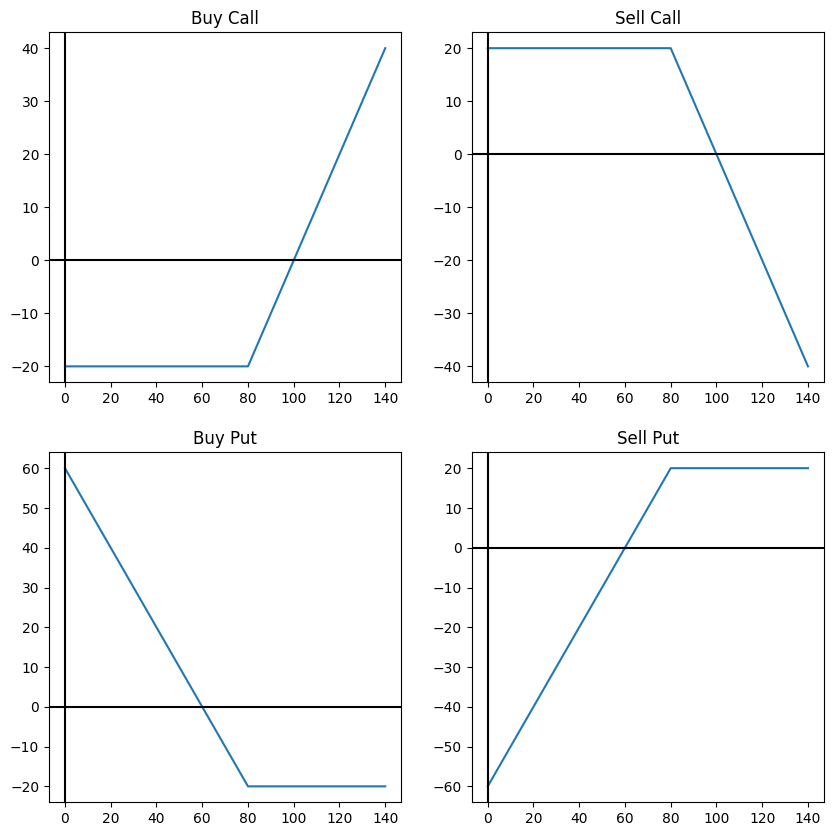

In [176]:
x = np.arange(0., 150., 10)
fig, axis = plt.subplots(2, 2, figsize=(10, 10))
axis[0, 0].plot(x, list(map(option1.f, x)))
axis[0, 0].set_title("Buy Call")
axis[0, 0].axhline(0, color='black')
axis[0, 0].axvline(0, color='black')

axis[0, 1].plot(x, list(map(option2.f, x)))
axis[0, 1].set_title("Sell Call")
axis[0, 1].axhline(0, color='black')
axis[0, 1].axvline(0, color='black')

axis[1, 0].plot(x, list(map(option3.f, x)))
axis[1, 0].set_title("Buy Put")
axis[1, 0].axhline(0, color='black')
axis[1, 0].axvline(0, color='black')

axis[1, 1].plot(x, list(map(option4.f, x)))
axis[1, 1].set_title("Sell Put")
axis[1, 1].axhline(0, color='black')
axis[1, 1].axvline(0, color='black')

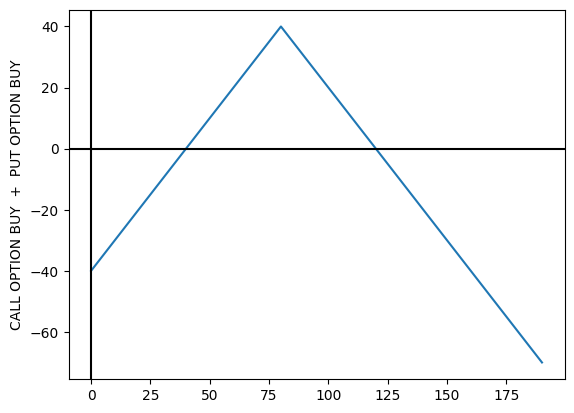

In [181]:
options = [option1, option3]
x = np.arange(0., 200., 10)
y = list(map(add, list(map(option2.f, x)), list(map(option4.f, x))))

plt.plot(x, y)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.ylabel("".join([str(option1), "  +  ", str(option3)]))
plt.show()